In [1]:
cd /home/users/cdonoso/astromer/ASTROMER/

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

from core.data import pretraining_records
from sklearn.metrics import precision_recall_fscore_support
from presentation.scripts.backprop import NormedLSTMCell
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Something GPU-related is solved when using the following lines.
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_prediction(data, folder):
    model = tf.keras.models.load_model(folder, custom_objects={'NormedLSTMCell':NormedLSTMCell})
    y_pred = model.predict(data)
    y_pred = tf.argmax(y_pred, 1)
    return y_pred

In [4]:
dataset_name = 'alcock'
num_cls = pd.read_csv(os.path.join('./data/records/{}/fold_0/{}/'.format(dataset_name, dataset_name), 'objects.csv')).shape[0]

In [20]:
# datasetx = 'ogle'
# model = tf.keras.models.load_model(
# './experiments/partial_ft/experiments_fixed_astromer/{}/fold_0/{}_500/lstm_att/model/'.format(datasetx,
#                                                                                           datasetx), custom_objects={'NormedLSTMCell':NormedLSTMCell})
# model.get_layer('encoder').trainable = False
# model.summary()

In [21]:
test_ds = pretraining_records(os.path.join('./data/records/{}/fold_0/{}/'.format(dataset_name,dataset_name), 'test/'),
                     1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                     sampling=False, shuffle=False,
                     n_classes=num_cls)
y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])

[INFO] Processing labels


2021-12-29 12:35:59.050844: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [ ]:
folds_df = []
for fold_n in range(3):
    results = []
    for model_name in ['lstm', 'lstm_att', 'mlp_att']:
        y_pred = get_prediction(test_ds, './experiments_8/{}/fold_{}/{}/{}/model/'.format(dataset_name, 
                                                                                          fold_n, 
                                                                                          dataset_name, model_name))
        prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
        results.append([dataset_name, model_name, f1, prec, reca])
        
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results['fold'] = [fold_n]*df_results.shape[0]
    folds_df.append(df_results)

In [ ]:
pd.concat(folds_df, 0).groupby('model').mean()

In [13]:
# y_true = tf.concat([tf.argmax(y, 1) for _, y in ds], 0)

In [20]:
dataset_name = 'new_ogle'
num_cls = pd.read_csv(
    os.path.join('./data/records/{}/fold_0/{}_500/'.format(dataset_name, 
                                                       dataset_name), 'objects.csv')).shape[0]

exp_path = './latest/training_astromer/big_ds/'

In [21]:
%%time
for fold_n in range(3):
    results = []
    for dataset in ['{}_20'.format(dataset_name),
                    '{}_50'.format(dataset_name), 
                    '{}_100'.format(dataset_name), 
                    '{}_500'.format(dataset_name)]:
        ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset)
#         ds_path = './data/records/{}/fold_{}/{}/'.format(dataset_name, fold_n, dataset_name)
        test_ds = pretraining_records(os.path.join(ds_path, 'test/'),
                             1000, max_obs=200, msk_frac=0., rnd_frac=0., same_frac=0.,
                                        sampling=False, shuffle=False,
                                        n_classes=num_cls)
        y_true = np.concatenate([np.argmax(y, 1) for _, y in test_ds])
        for model_name in ['lstm', 'lstm_att', 'mlp_att']:
            path = '{}/{}/fold_{}/{}/'.format(exp_path, dataset_name, fold_n, dataset)
            try:
                y_pred = get_prediction(test_ds, os.path.join(path, model_name, 'model'))
            except Exception as e:
                print(e)
                print(path)
                continue
                
            prec, reca, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
            results.append([dataset, model_name, f1, prec, reca])
            
    df_results = pd.DataFrame(results, columns=['exp', 'model', 'f1', 'recall', 'precision'])
    df_results.to_csv('{}/{}/results_{}.csv'.format(exp_path, dataset_name, fold_n), index=False)

[INFO] Processing labels


2022-01-07 17:37:07.480824: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:08.693780: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:08.783850: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:09.532656: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:09.544984: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _ou

[INFO] Processing labels


2022-01-07 17:37:54.514213: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:55.024988: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:55.048702: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:55.526696: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:37:55.838216: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _ou

[INFO] Processing labels


2022-01-07 17:38:40.932262: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:38:40.945025: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:38:41.889283: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:38:42.358801: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:38:42.375442: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels
SavedModel file does not exist at: ./latest/training_astromer/big_ds//new_ogle/fold_0/new_ogle_500/lstm_att/model/{saved_model.pbtxt|saved_model.pb}
./latest/training_astromer/big_ds//new_ogle/fold_0/new_ogle_500/
[INFO] Processing labels


2022-01-07 17:39:55.823200: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:39:55.933632: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:39:55.945879: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:39:56.216800: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:39:56.229031: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2022-01-07 17:40:40.839755: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:40:40.852336: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:40:41.540244: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:40:41.552602: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:40:41.865090: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

[INFO] Processing labels


2022-01-07 17:41:29.313226: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:41:29.325857: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:41:29.561895: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:41:29.574347: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:41:30.118440: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

[INFO] Processing labels
SavedModel file does not exist at: ./latest/training_astromer/big_ds//new_ogle/fold_1/new_ogle_500/lstm_att/model/{saved_model.pbtxt|saved_model.pb}
./latest/training_astromer/big_ds//new_ogle/fold_1/new_ogle_500/
[INFO] Processing labels


2022-01-07 17:42:42.585762: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:42:43.131356: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:42:43.211622: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:42:43.654851: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:42:44.253640: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _ou

[INFO] Processing labels


2022-01-07 17:43:28.791451: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:43:31.463747: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:43:31.476176: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:43:31.529408: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:43:31.541612: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

[INFO] Processing labels


2022-01-07 17:44:15.028688: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:44:15.525779: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:44:15.538473: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:44:15.892406: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:44:17.629323: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_sh

[INFO] Processing labels


2022-01-07 17:45:04.930467: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:45:04.942862: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:45:05.149515: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:45:06.016617: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-01-07 17:45:06.029035: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'cond' has 5 outputs but the _output_sh

CPU times: user 12min 13s, sys: 55.9 s, total: 13min 9s
Wall time: 8min 42s


In [16]:
dataname = 'new_alcock'
fold_0 = pd.read_csv('{}/{}/results_0.csv'.format(exp_path, dataname))
fold_1 = pd.read_csv('{}/{}/results_1.csv'.format(exp_path, dataname))
fold_2 = pd.read_csv('{}/{}/results_2.csv'.format(exp_path, dataname))

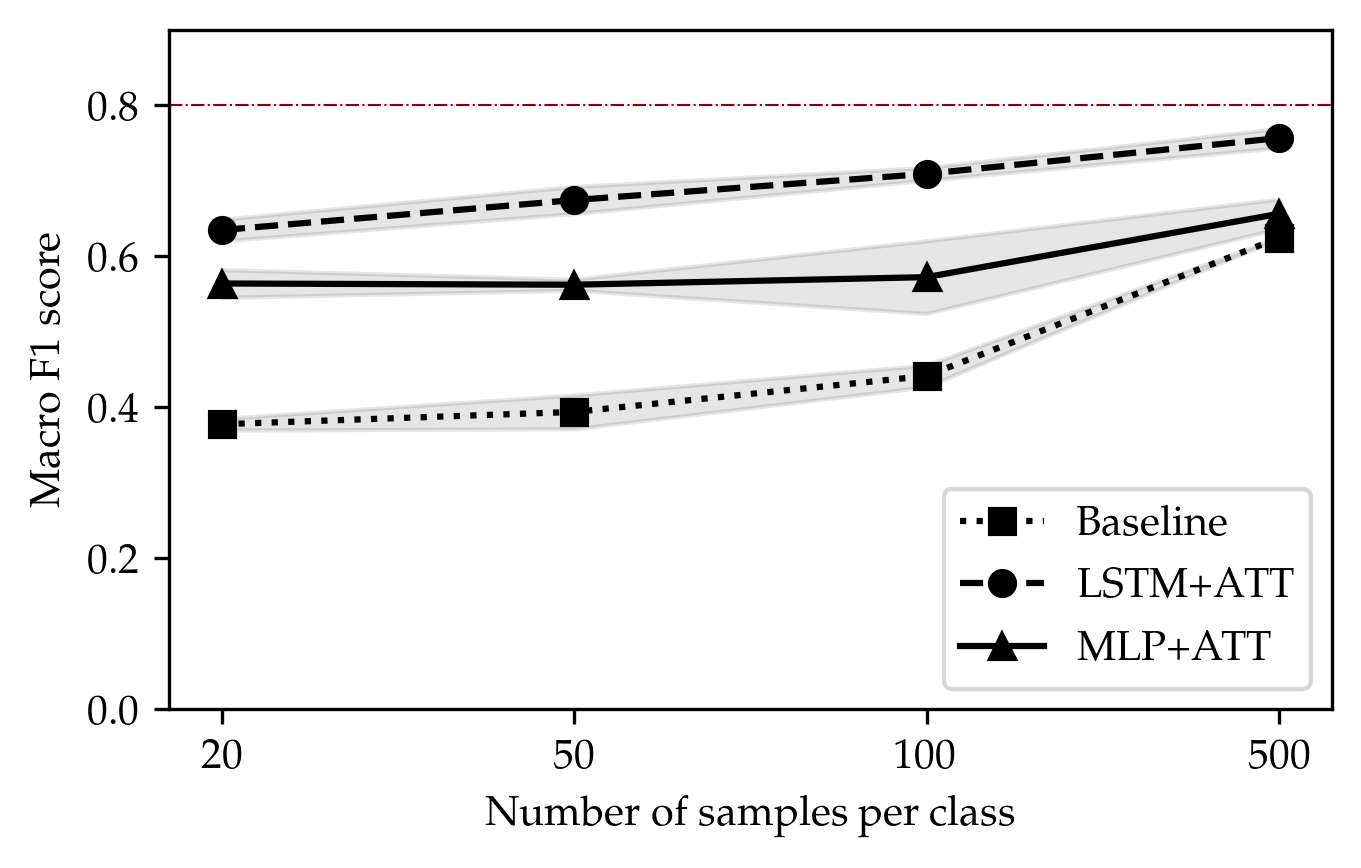

In [17]:
plt.figure(figsize=(5,3), dpi=300)
for (exp0, g0), (exp1, g1), (exp2, g2), ls in zip(fold_0.groupby('model'), 
                                              fold_1.groupby('model'), 
                                              fold_2.groupby('model'), [['s', ':'], ['o', '--'], ['^', '-']]):
    

    f1_mean = np.mean([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
    f1_std = np.std([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)

    xrange = range(len(g0['exp'][:]))    
    
    if exp0 == 'lstm':
        exp0 = 'Baseline'  
    if exp0 == 'lstm_att':
        exp0 = 'LSTM+ATT'  
    if exp0 == 'mlp_att':
        exp0 = 'MLP+ATT'  
        
    plt.plot(xrange, f1_mean, marker=ls[0],label=exp0, linestyle=ls[1], color='k')
    plt.fill_between(xrange, f1_mean+f1_std, f1_mean-f1_std, alpha=0.1, color='k')
    plt.xticks(xrange, [x.split('_')[-1] for x in g0['exp'][:]])

plt.axhline(y=0.8, linewidth=0.5, linestyle='-.', color='darkred')
plt.ylim(0, 0.9)
plt.ylabel('Macro F1 score')
plt.xlabel('Number of samples per class')
plt.legend(loc='lower right')
plt.savefig('./presentation/figures/{}_partial_no_train.pdf'.format(dataname), format='pdf', bbox_inches='tight')
plt.show()

In [23]:
fold_0_2 = pd.read_csv('./experiments/partial_ft/experiments_training_astromer/{}/results_0.csv'.format(dataname))
fold_1_2 = pd.read_csv('./experiments/partial_ft/experiments_training_astromer/{}/results_1.csv'.format(dataname))
fold_2_2 = pd.read_csv('./experiments/partial_ft/experiments_training_astromer/{}/results_2.csv'.format(dataname))

[0.61737896 0.65242465 0.70900401 0.77579086]


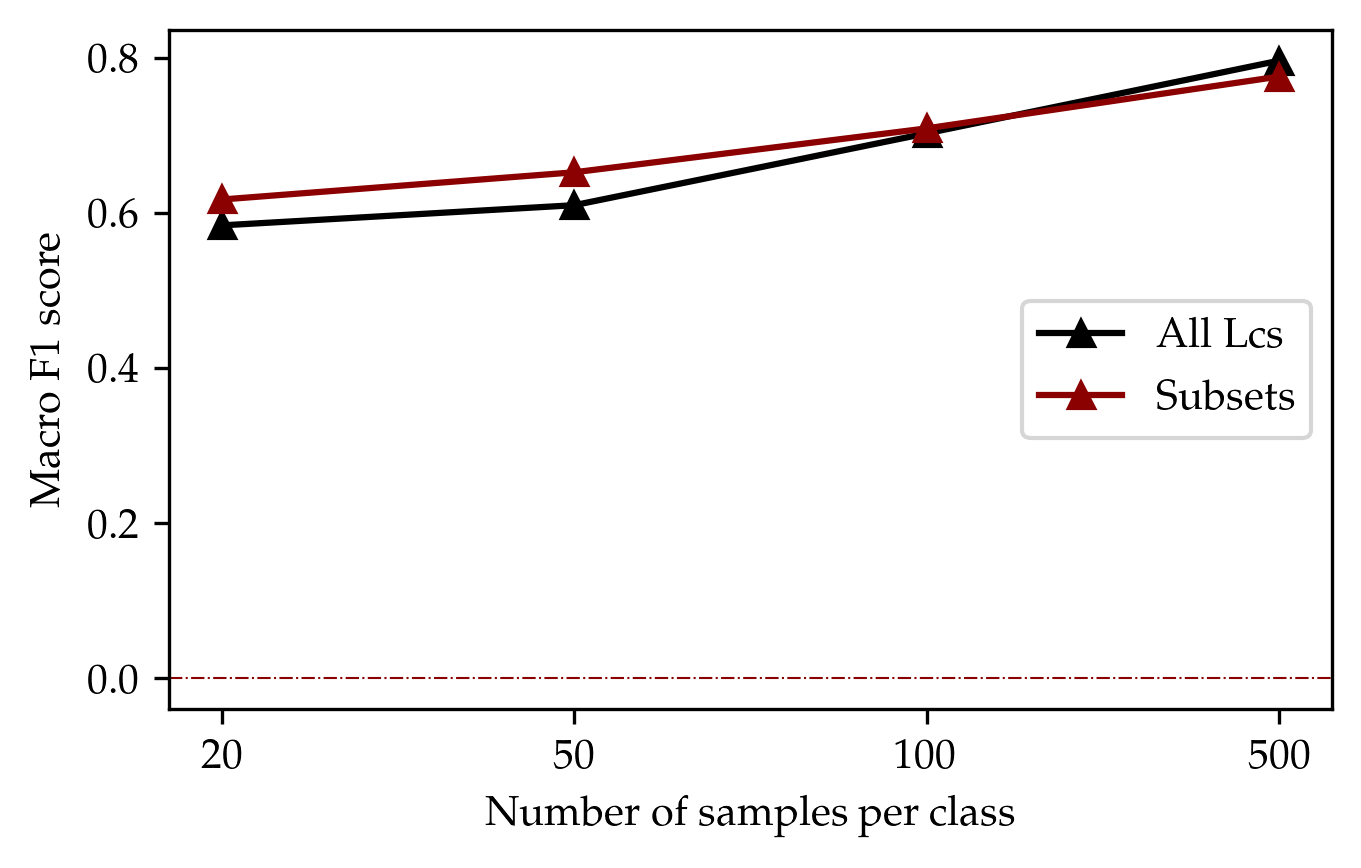

In [27]:
plt.figure(figsize=(5,3), dpi=300)
for (exp0, g0), (exp1, g1), (exp2, g2), \
    (exp0_2, g0_2), (exp1_2, g1_2), (exp2_2, g2_2), ls in zip(fold_0.groupby('model'), 
                                                              fold_1.groupby('model'), 
                                                              fold_2.groupby('model'), 
                                                              fold_0_2.groupby('model'),
                                                              fold_1_2.groupby('model'),
                                                              fold_2_2.groupby('model'),
                                                              [['s', ':'], ['o', '--'], ['^', '-']]):
    

    f1_mean = np.mean([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
    f1_std = np.std([g0['f1'][:], g1['f1'][:], g2['f1'][:]], 0)
    
    f1_mean_2 = np.mean([g0_2['f1'][:], g1_2['f1'][:], g2_2['f1'][:]], 0)
    f1_std_2 = np.std([g0_2['f1'][:], g1_2['f1'][:], g2_2['f1'][:]], 0)

    xrange = range(len(g0['exp'][:]))    
    
    if exp0 == 'lstm':
        exp0 = 'Baseline'  
        continue
        
    if exp0 == 'lstm_att':
        exp0 = 'LSTM+ATT' 
        continue
    if exp0 == 'mlp_att':
        exp0 = 'MLP+ATT'  
    
    print(f1_mean)
    plt.errorbar(xrange, f1_mean, marker=ls[0],label='Subsets', linestyle=ls[1], color='darkred')
    
    plt.plot(xrange, f1_mean_2, marker=ls[0],label='All Lcs', linestyle=ls[1], color='k')
#     plt.fill_between(xrange, f1_mean+f1_std, f1_mean-f1_std, alpha=0.1, color='k')
    plt.xticks(xrange, [x.split('_')[-1] for x in g0['exp'][:]])

plt.axhline(y=0., linewidth=0.5, linestyle='-.', color='darkred')
# plt.ylim(0, 0.9)
plt.ylabel('Macro F1 score')
plt.xlabel('Number of samples per class')
plt.legend(loc='best')
plt.savefig('./presentation/figures/{}_whole_train.pdf'.format(dataname), format='pdf', bbox_inches='tight')
plt.show()

In [7]:
from tensorboard.backend.event_processing import event_accumulator
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)
def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()
    
    metrics = {tag:[] for tag in ea.Tags()['scalars']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue

            value = v.simple_value#tf.make_ndarray()
            
            metrics[v.tag].append(value)
    return metrics

In [258]:
exp_folder = './experiments/partial_ft/experiments_fixed_astromer/ogle/fold_1/ogle_500/'

Text(0, 0.5, 'Loss')

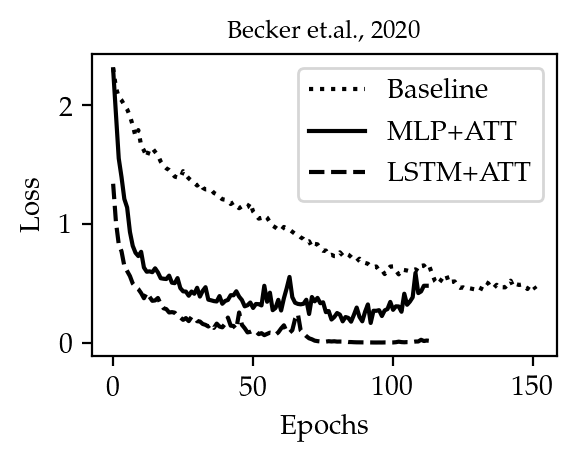

In [259]:
fig, axes = plt.subplots(1,1, sharey=True,sharex=True, figsize=(3,2), dpi=200, 
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},)
for index, (name, ls) in enumerate(zip(['lstm', 'mlp_att', 'lstm_att'], [':', '-', '--'])):
#     if name != 'lstm':continue

    val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
    train_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'train'))
#     print(train_metrics.keys())
#     axes[index].plot(train_metrics['epoch_accuracy'], label='train')

    if name =='lstm': title_name = 'Baseline'
    if name =='mlp_att': title_name = 'MLP+ATT'
    if name =='lstm_att': title_name = 'LSTM+ATT'
        
    axes.plot(val_metrics['epoch_loss'], label=title_name, linestyle=ls, color='k')

axes.legend()
axes.set_title('Becker et.al., 2020', fontsize=9)
axes.set_xlabel('Epochs')
axes.set_ylabel('Loss')
# fig.text(0.5, -0.1, 'Epochs', ha='center')
# fig.text(0.0, 0.5, 'Validation loss', va='center', rotation='vertical')

In [260]:
fig.savefig('./presentation/figures/ogle_learning_curves.pdf', format='pdf',  bbox_inches='tight')

In [279]:
n_epochs = {'lstm':[], 'lstm_att':[], 'mlp_att':[]}
for nsamples in [50, 100, 500]:
    for dataset in ['alcock', 'ogle']:
        for fold_n in range(3):
            exp_folder = './experiments/partial_ft/experiments_fixed_astromer/{}/fold_{}/{}_{}/'.format(dataset, 
                                                                                                        fold_n,
                                                                                                        dataset,
                                                                                                        nsamples)

            for index, (name, ls) in enumerate(zip(['lstm', 'mlp_att', 'lstm_att'], [':', '-', '--'])):
            #     if name != 'lstm':continue

                val_metrics = get_metrics(os.path.join(exp_folder, name, 'logs', 'validation'))
                min_loss_epoch = np.argmin(val_metrics['epoch_loss'])
                if min_loss_epoch < 1000:               
                    n_epochs[name].append(min_loss_epoch)

In [289]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['lstm']), np.std(n_epochs['lstm']))

'258 +- 74'

In [290]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['lstm_att']), np.std(n_epochs['lstm_att']))

'143 +- 102'

In [291]:
'{:.0f} +- {:.0f}'.format(np.mean(n_epochs['mlp_att']), np.std(n_epochs['mlp_att']))

'112 +- 29'